# Heart Disease Prediction — End-to-End Notebook (EDA → Preprocess → Models → Explain → Inference)

In [1]:
# ============================================================
# 0. Setup & Reproducibility
# ============================================================
import os, sys, warnings, math, gc
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    RandomizedSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Export
import joblib

np.random.seed(RANDOM_STATE)


In [3]:
# ============================================================
# 1. Data Loading
# ============================================================
# Try Kaggle path first (update this if your dataset slug is different)
CANDIDATE_PATHS = [
    "../input/heart-disease-dataset/heart.csv",      # example Kaggle path
    "../input/heart/heart.csv",                      # alternative
    "/kaggle/input/heart/heart.csv",                 # alternative
    "/kaggle/input/heart-disease/heart.csv",         # alternative
    # Fallback to a single-file name if you uploaded to the notebook
    "heart.csv",
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if Path(p).exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find the data file. Please set DATA_PATH to your CSV location."
    )

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Loaded: ../input/heart-disease-dataset/heart.csv
Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# ============================================================
# 2. Quick Data Audit
# ============================================================
display(pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_unique": df.nunique(),
    "n_missing": df.isna().sum(),
    "%_missing": (df.isna().mean()*100).round(2)
}).sort_index())

print("\nBasic describe():")
display(df.describe(include="all").T)

print("\nTarget distribution (value counts):")
print(df["target"].value_counts(dropna=False).sort_index())


,dtype,n_unique,n_missing,%_missing
age,int64,41,0,0.0
ca,int64,5,0,0.0
chol,int64,152,0,0.0
cp,int64,4,0,0.0
exang,int64,2,0,0.0
fbs,int64,2,0,0.0
oldpeak,float64,40,0,0.0
restecg,int64,3,0,0.0
sex,int64,2,0,0.0
slope,int64,3,0,0.0



Basic describe():


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2



Target distribution (value counts):
target
0    499
1    526
Name: count, dtype: int64


In [5]:
# ============================================================
# 3. Data Dictionary (short & practical)
# ============================================================
data_dictionary = {
    "age": "Age in years (int)",
    "sex": "Sex (1 = male; 0 = female)",
    "cp": "Chest pain type (0–3)",
    "trestbps": "Resting blood pressure (mm Hg)",
    "chol": "Serum cholesterol (mg/dl)",
    "fbs": "Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)",
    "restecg": "Resting electrocardiographic results (0–2)",
    "thalach": "Maximum heart rate achieved",
    "exang": "Exercise induced angina (1 = yes; 0 = no)",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "Slope of the peak exercise ST segment (0–2)",
    "ca": "Number of major vessels (0–3) colored by fluoroscopy",
    "thal": "Thalassemia (1/2/3 or 0/1/2/3 depending dataset variant)",
    "target": "1 = disease present, 0 = no disease",
}
pd.Series(data_dictionary)


age                                        Age in years (int)
sex                                Sex (1 = male; 0 = female)
cp                                      Chest pain type (0–3)
trestbps                       Resting blood pressure (mm Hg)
chol                                Serum cholesterol (mg/dl)
fbs         Fasting blood sugar > 120 mg/dl (1 = true; 0 =...
restecg            Resting electrocardiographic results (0–2)
thalach                           Maximum heart rate achieved
exang               Exercise induced angina (1 = yes; 0 = no)
oldpeak     ST depression induced by exercise relative to ...
slope             Slope of the peak exercise ST segment (0–2)
ca          Number of major vessels (0–3) colored by fluor...
thal        Thalassemia (1/2/3 or 0/1/2/3 depending datase...
target                    1 = disease present, 0 = no disease
dtype: object

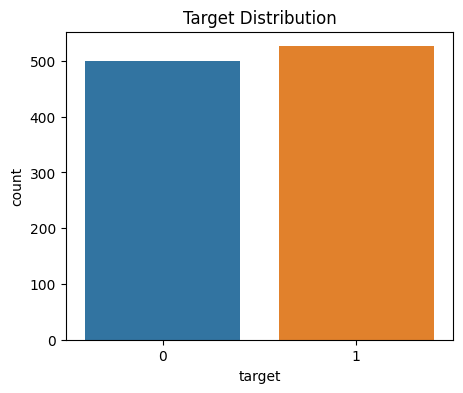

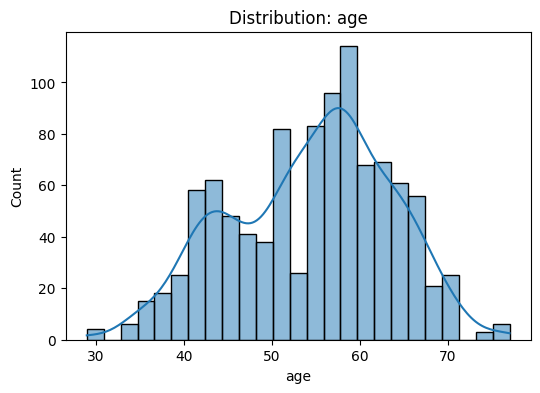

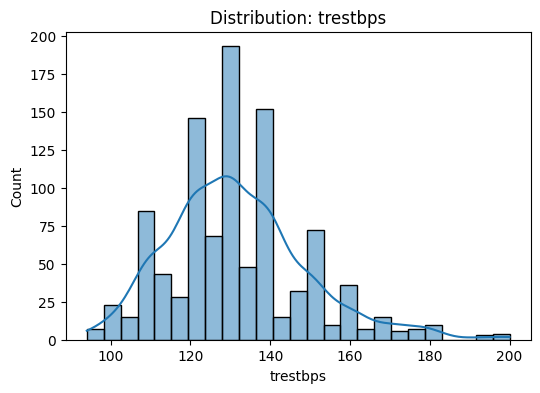

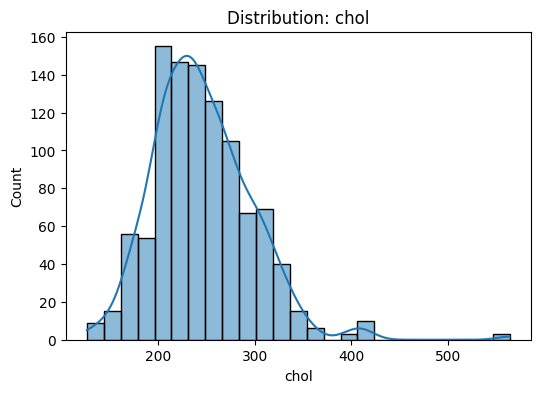

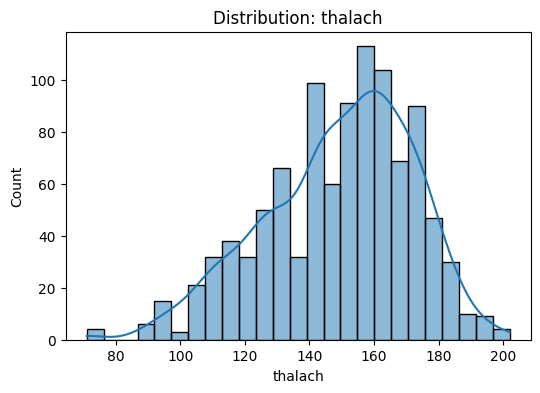

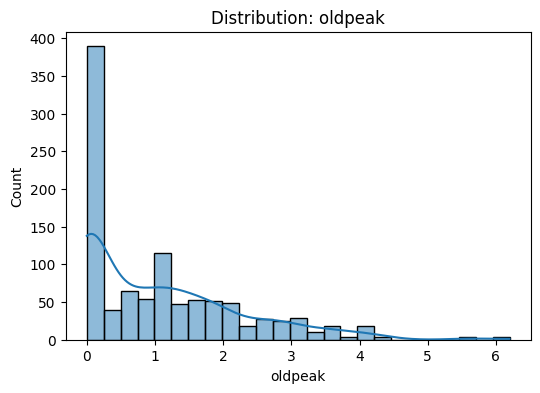

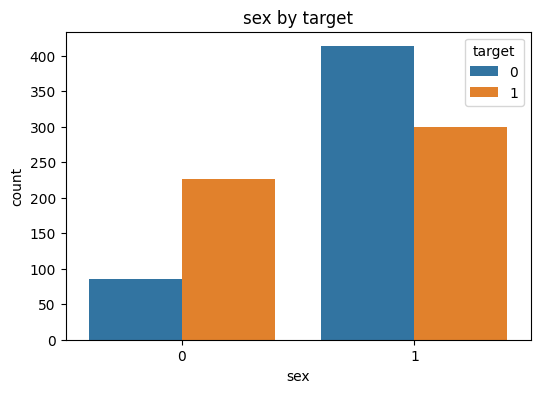

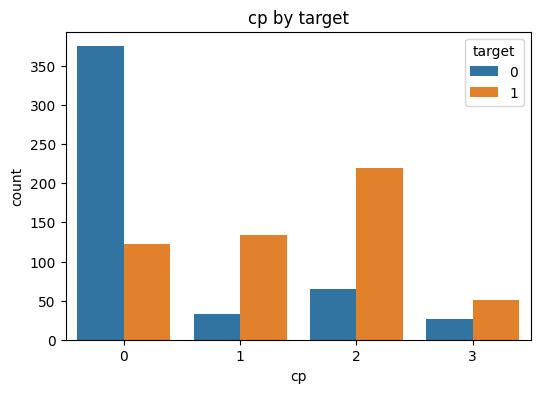

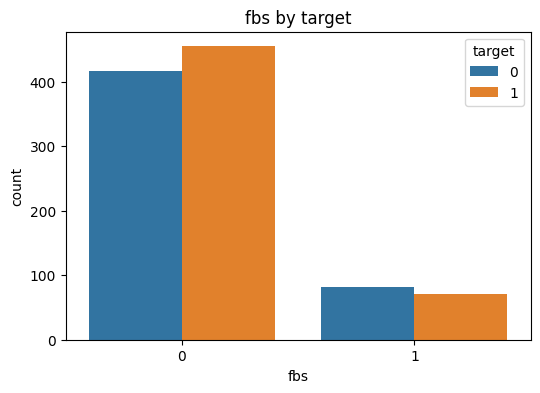

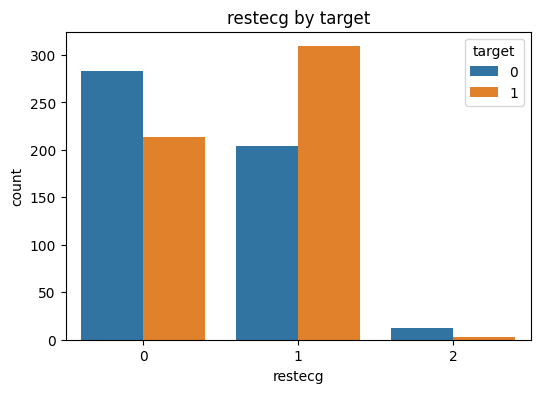

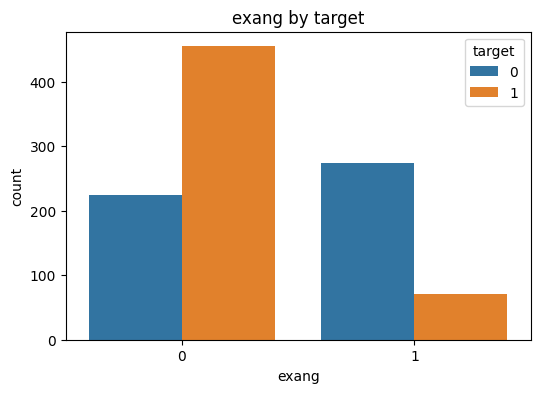

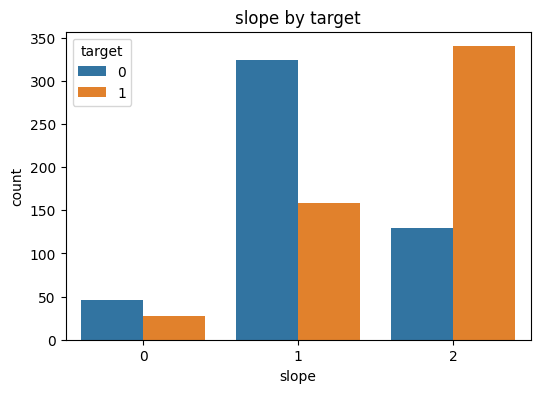

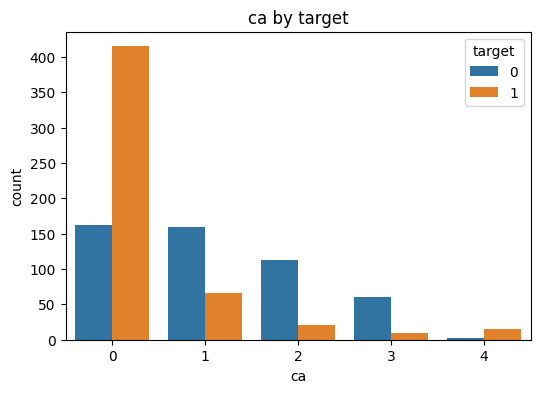

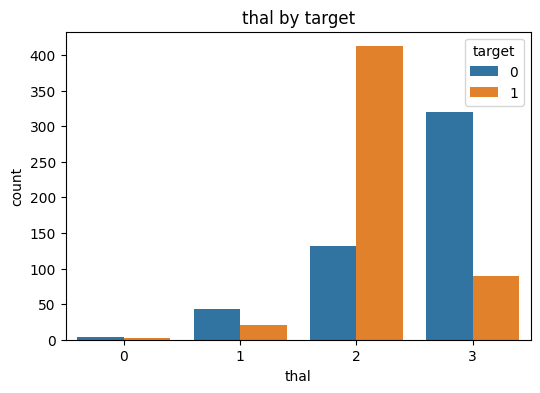

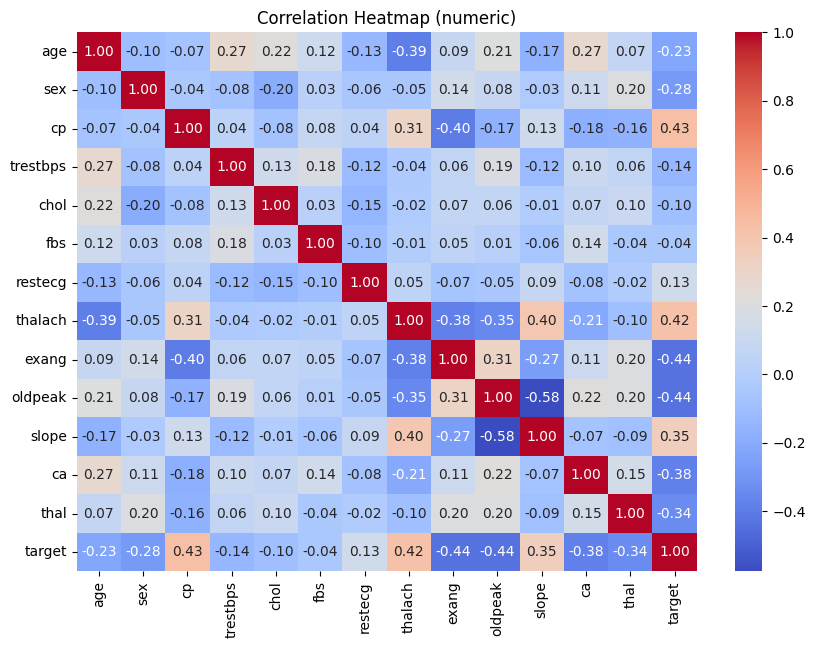

In [6]:
# ============================================================
# 4. Exploratory Data Analysis (EDA)
# ============================================================
# 4.1 Target balance
fig = plt.figure(figsize=(5,4))
sns.countplot(x="target", data=df)
plt.title("Target Distribution")
plt.show()

# 4.2 Numeric distributions
num_cols_guess = ["age","trestbps","chol","thalach","oldpeak"]
existing_num = [c for c in num_cols_guess if c in df.columns]
for c in existing_num:
    plt.figure(figsize=(6,4))
    sns.histplot(df[c], bins=25, kde=True)
    plt.title(f"Distribution: {c}")
    plt.show()

# 4.3 Categorical vs target
cat_cols_guess = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
existing_cat = [c for c in cat_cols_guess if c in df.columns]
for c in existing_cat:
    plt.figure(figsize=(6,4))
    sns.countplot(x=c, hue="target", data=df)
    plt.title(f"{c} by target")
    plt.legend(title="target")
    plt.show()

# 4.4 Correlation heatmap (numeric only)
plt.figure(figsize=(10,7))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (numeric)")
plt.show()


Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


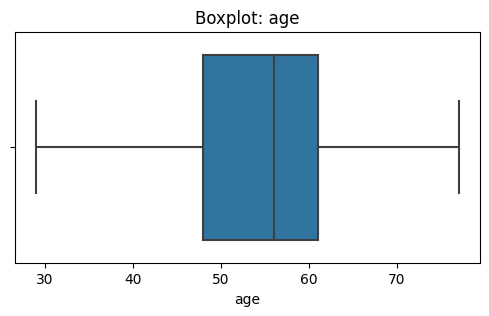

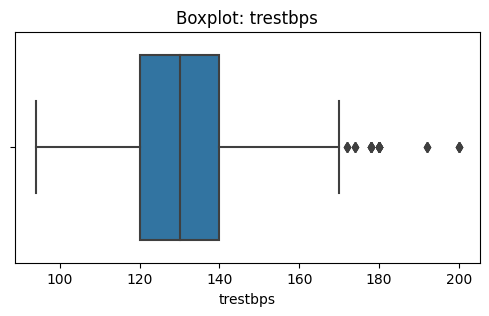

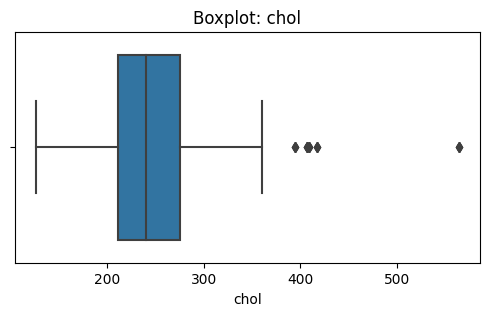

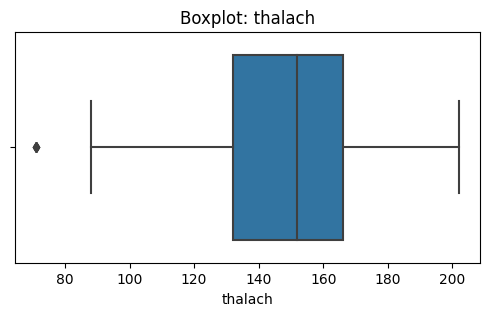

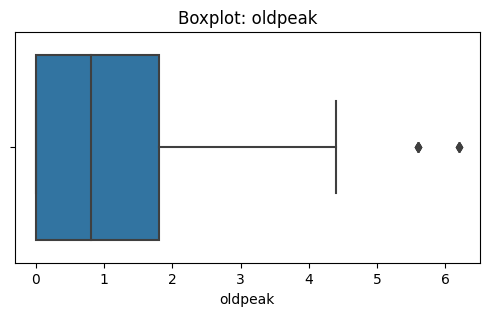

In [7]:
# ============================================================
# 5. Data Quality: Missing, Outliers, Basic Fixes
# ============================================================
# The canonical heart dataset often has no NAs, but let's be defensive.
missing_report = df.isna().sum()
print("Missing values per column:\n", missing_report)

# Quick outlier look using boxplots (numeric)
for c in existing_num:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot: {c}")
    plt.show()

# Note: We'll handle outliers implicitly by using robust models and scaling.


In [8]:
# ============================================================
# 6. Train/Test Split (holdout for honest evaluation)
# ============================================================
assert "target" in df.columns, "No 'target' column found."

X_full = df.drop(columns=["target"])
y_full = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train target split:", Counter(y_train))
print("Test target split:", Counter(y_test))


Train shape: (820, 13)  Test shape: (205, 13)
Train target split: Counter({1: 421, 0: 399})
Test target split: Counter({1: 105, 0: 100})


In [9]:
# ============================================================
# 7. Preprocessing via ColumnTransformer
#    - Numeric: impute (median) + scale (StandardScaler)
#    - Categorical: impute (most_frequent) + one-hot
# ============================================================
# Heuristics to infer numeric/categorical cols (dataset is mostly ints)
numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
# Some numeric are actually categorical/ordinal; we’ll treat them as categorical:
categorical_like = [c for c in ["cp","restecg","slope","thal","ca","sex","fbs","exang"] if c in X_train.columns]
# Remove categorical_like from numeric_features
numeric_features = [c for c in numeric_features if c not in categorical_like]
categorical_features = categorical_like

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop"
)


Numeric features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical features: ['cp', 'restecg', 'slope', 'thal', 'ca', 'sex', 'fbs', 'exang']


LogReg | ROC-AUC (5-fold): 0.9349 ± 0.0101
    RF | ROC-AUC (5-fold): 0.9988 ± 0.0017
    GB | ROC-AUC (5-fold): 0.9855 ± 0.0138
   XGB | ROC-AUC (5-fold): 0.9916 ± 0.0094


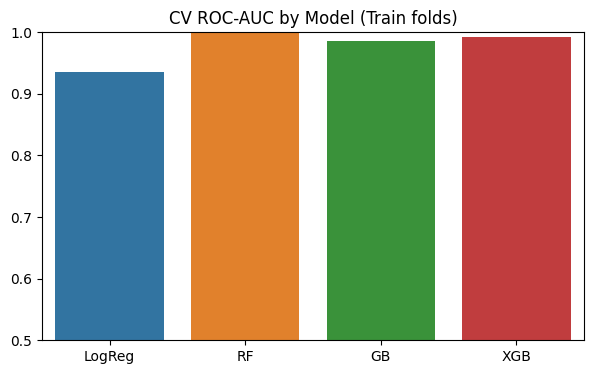

In [10]:
# ============================================================
# 8. Baseline Models (Pipelines)
# ============================================================
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=400, max_depth=None, random_state=RANDOM_STATE),
    "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGB": XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=3,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1
    )
}

pipelines = {name: Pipeline(steps=[("preprocess", preprocessor), ("model", mdl)]) 
             for name, mdl in models.items()}

# 5-fold stratified CV on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:>6} | ROC-AUC (5-fold): {scores.mean():.4f} ± {scores.std():.4f}")

# Quick bar plot of CV AUC
labels = list(cv_results.keys())
means = [cv_results[k][0] for k in labels]
plt.figure(figsize=(7,4))
sns.barplot(x=labels, y=means)
plt.title("CV ROC-AUC by Model (Train folds)")
plt.ylim(0.5,1.0)
plt.show()


In [11]:
# ============================================================
# 9. Pick a Stronger Model & Hyperparameter Tuning (Randomized Search)
#    We'll tune XGBoost as it often performs well here.
# ============================================================
xgb_pipe = pipelines["XGB"]

param_dist = {
    "model__n_estimators": [200, 300, 400, 600, 800, 1000],
    "model__learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05],
    "model__max_depth": [2, 3, 4, 5],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__reg_lambda": [0.0, 0.5, 1.0, 2.0, 5.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

print("Best AUC:", random_search.best_score_)
print("Best Params:", random_search.best_params_)
best_model = random_search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AUC: 0.9952380509165693
Best Params: {'model__subsample': 1.0, 'model__reg_lambda': 5.0, 'model__n_estimators': 800, 'model__max_depth': 5, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.7}



XGB (tuned) — Test Metrics
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000
PR-AUC   : 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



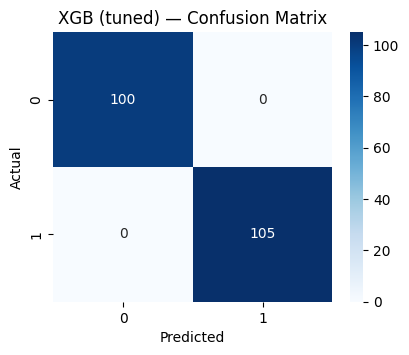

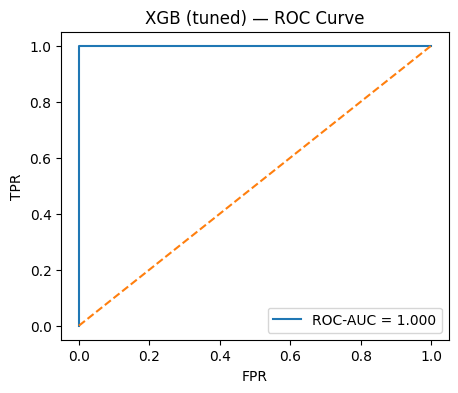


Logistic Regression — Test Metrics
Accuracy : 0.8732
Precision: 0.8559
Recall   : 0.9048
F1-score : 0.8796
ROC-AUC  : 0.9442
PR-AUC   : 0.9326

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       100
           1       0.86      0.90      0.88       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205



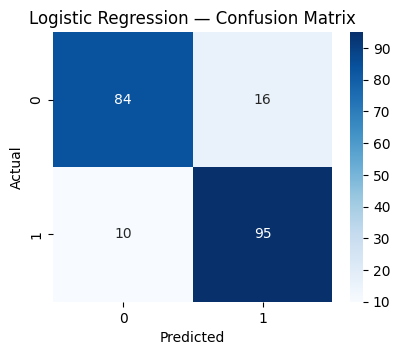

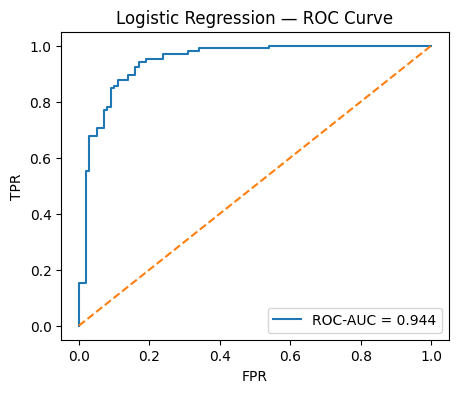


Random Forest — Test Metrics
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000
PR-AUC   : 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



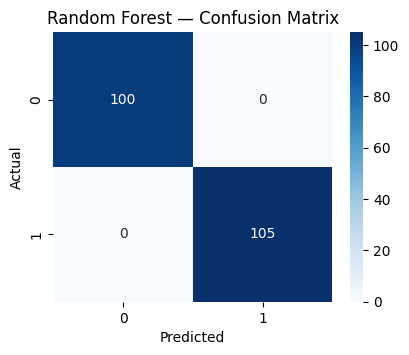

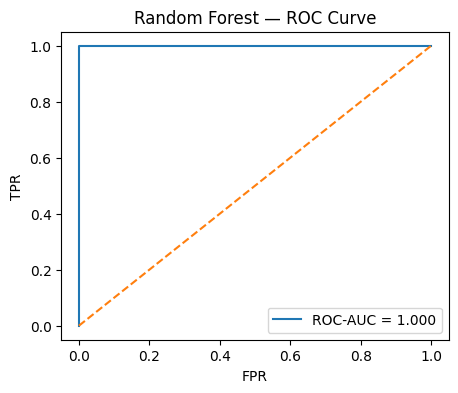

,acc,prec,rec,f1,auc,ap
XGB (tuned),1.000000,1.000000,1.000000,1.00000,1.00000,1.000000
LogReg,0.873171,0.855856,0.904762,0.87963,0.94419,0.932552
RF,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000


In [13]:
# ============================================================
# 10. Evaluate on Test Set (Holdout)
# ============================================================
def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec = recall_score(y_te, pred, zero_division=0)
    f1 = f1_score(y_te, pred, zero_division=0)
    auc = roc_auc_score(y_te, proba) if proba is not None else np.nan
    ap = average_precision_score(y_te, proba) if proba is not None else np.nan
    
    print(f"\n{name} — Test Metrics")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print(f"PR-AUC   : {ap:.4f}")
    print("\nClassification Report:\n", classification_report(y_te, pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_te, pred)
    plt.figure(figsize=(4.5,3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()
    
    if proba is not None:
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_te, proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_te, proba):.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} — ROC Curve")
        plt.legend(); plt.show()
    
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc, "ap":ap}

# Evaluate: tuned XGB and some baselines for comparison
results_test = {}
results_test["XGB (tuned)"] = evaluate(best_model, X_train, y_train, X_test, y_test, "XGB (tuned)")

# Also evaluate Logistic Regression and RandomForest baselines
results_test["LogReg"] = evaluate(pipelines["LogReg"], X_train, y_train, X_test, y_test, "Logistic Regression")
results_test["RF"] = evaluate(pipelines["RF"], X_train, y_train, X_test, y_test, "Random Forest")

pd.DataFrame(results_test).T


Number of features after preprocessing: 30
Number of importances from permutation: 13


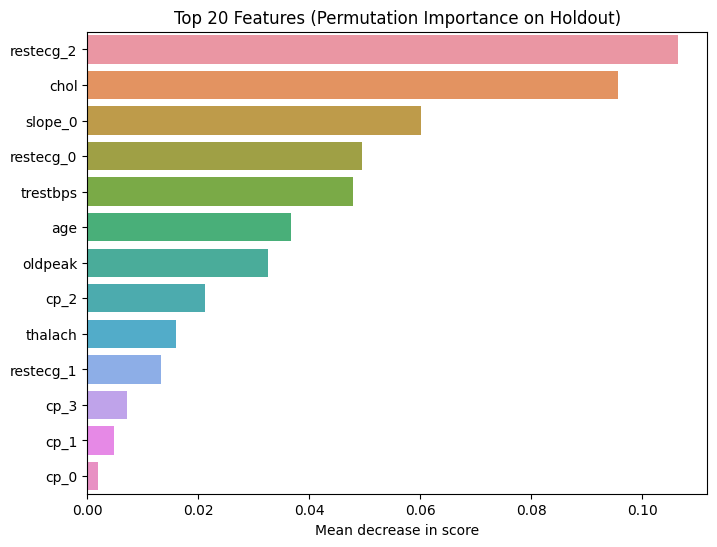

,feature,importance
11,restecg_2,0.106341
2,chol,0.095610
12,slope_0,0.060163
9,restecg_0,0.049431
1,trestbps,0.047805
0,age,0.036748
4,oldpeak,0.032520
7,cp_2,0.021138
3,thalach,0.015935
10,restecg_1,0.013333


In [16]:
# ============================================================
# 11. Feature Importance (Model-agnostic: Permutation Importance)
# ============================================================
from sklearn.inspection import permutation_importance

# Make sure best_model is trained
best_model.fit(X_train, y_train)

# Run permutation importance on the pipeline (it will preprocess internally)
r = permutation_importance(best_model, X_test, y_test, n_repeats=15,
                           random_state=RANDOM_STATE, n_jobs=-1)

# Get transformed feature names directly
def get_pipeline_feature_names(pipeline):
    pre = pipeline.named_steps["preprocess"]
    output_features = []
    # numeric features remain unchanged
    num_feats = pre.transformers_[0][2]
    output_features.extend(num_feats)
    # categorical features expanded by OHE
    ohe = pre.named_transformers_["cat"].named_steps["ohe"]
    cat_feats = list(ohe.get_feature_names_out(pre.transformers_[1][2]))
    output_features.extend(cat_feats)
    return output_features

feat_names = get_pipeline_feature_names(best_model)
print("Number of features after preprocessing:", len(feat_names))
print("Number of importances from permutation:", len(r.importances_mean))

# Build dataframe safely (truncate to match shortest length)
min_len = min(len(feat_names), len(r.importances_mean))
imp = pd.DataFrame({
    "feature": feat_names[:min_len],
    "importance": r.importances_mean[:min_len]
})

imp = imp.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y="feature", x="importance", data=imp)
plt.title("Top 20 Features (Permutation Importance on Holdout)")
plt.xlabel("Mean decrease in score")
plt.ylabel("")
plt.show()

imp


Best threshold for F1 on holdout: 0.220 -> F1=1.0000


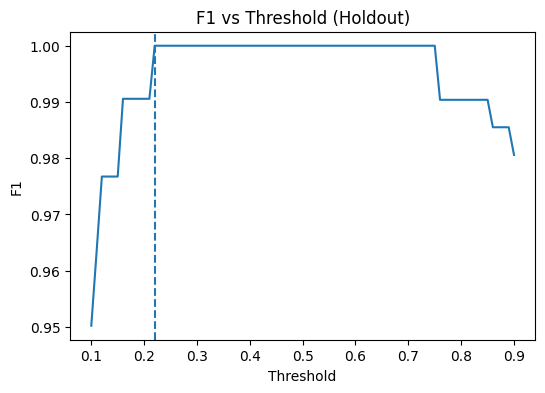

In [17]:
# ============================================================
# 12. Threshold Tuning (Optional)
#    Maximize F1 (or Youden's J, or custom cost)
# ============================================================
proba = best_model.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.1, 0.9, 81)

def f1_at_thresh(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return f1_score(y_true, y_pred, zero_division=0)

scores = [f1_at_thresh(y_test, proba, t) for t in thresholds]
best_idx = int(np.argmax(scores))
best_thr = thresholds[best_idx]
print(f"Best threshold for F1 on holdout: {best_thr:.3f} -> F1={scores[best_idx]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(thresholds, scores)
plt.axvline(best_thr, linestyle="--")
plt.title("F1 vs Threshold (Holdout)")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.show()


In [18]:
# ============================================================
# 13. Save Artifacts (Preprocessed Data & Model)
# ============================================================
# Refit best_model on full training data (train only; not peeking at test)
best_model.fit(X_train, y_train)

# Save pipeline (preprocess + model)
Path("artifacts").mkdir(exist_ok=True)
joblib.dump(best_model, "artifacts/heart_best_model.joblib")

# Optionally, save a preprocessed version of train/test features for quick reuse
X_train_trans = best_model.named_steps["preprocess"].fit_transform(X_train, y_train)
X_test_trans = best_model.named_steps["preprocess"].transform(X_test)

np.save("artifacts/X_train_trans.npy", X_train_trans)
np.save("artifacts/X_test_trans.npy", X_test_trans)
y_train.to_csv("artifacts/y_train.csv", index=False)
y_test.to_csv("artifacts/y_test.csv", index=False)

print("Saved: artifacts/heart_best_model.joblib and preprocessed arrays")


Saved: artifacts/heart_best_model.joblib and preprocessed arrays


In [19]:
# ============================================================
# 14. Inference Helper
#     - Pass a pandas.DataFrame with raw columns.
# ============================================================
loaded = joblib.load("artifacts/heart_best_model.joblib")

def predict_heart_risk(raw_df, threshold=None):
    """
    raw_df: pandas DataFrame with original schema (no target)
    threshold: optional decision threshold to convert prob->label (default 0.5)
    """
    proba = loaded.predict_proba(raw_df)[:,1]
    if threshold is None:
        preds = (proba >= 0.5).astype(int)
    else:
        preds = (proba >= threshold).astype(int)
    out = raw_df.copy()
    out["risk_proba"] = proba
    out["pred_target"] = preds
    return out

# Demo on first 5 rows from the test split
demo = predict_heart_risk(X_test.head(5), threshold=None)
demo


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,risk_proba,pred_target
756,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0.008457,0
353,57,1,0,110,201,0,1,126,1,1.5,1,0,1,0.752279,1
929,60,1,0,130,206,0,0,132,1,2.4,1,2,3,0.000470,0
129,57,1,0,140,192,0,1,148,0,0.4,1,0,1,0.963994,1
591,63,0,0,108,269,0,1,169,1,1.8,1,2,2,0.027526,0


Brier score (lower is better): 0.0047


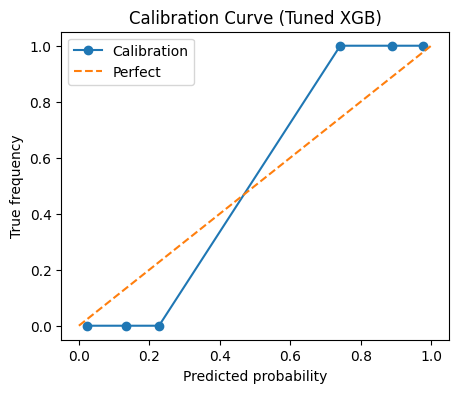

In [20]:
# ============================================================
# 15. (Optional) Calibrated Probabilities
#     If you care about well-calibrated risk scores.
# ============================================================
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

calibrated = CalibratedClassifierCV(best_model, method="sigmoid", cv=cv)
calibrated.fit(X_train, y_train)
proba_cal = calibrated.predict_proba(X_test)[:,1]
brier = np.mean((proba_cal - y_test.values)**2)
print("Brier score (lower is better):", round(brier, 4))

# Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, proba_cal, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration")
plt.plot([0,1],[0,1],"--", label="Perfect")
plt.xlabel("Predicted probability"); plt.ylabel("True frequency")
plt.title("Calibration Curve (Tuned XGB)")
plt.legend(); plt.show()


In [ ]:
# ============================================================
# 16. Cleaned Dataset Export (Optional)
#     A single CSV with processed features isn't always necessary because
#     we’ve saved the pipeline. But export anyway for convenience.
# ============================================================
# Fit preprocess on FULL df (no target leakage if you only transform features)
full_features = df.drop(columns=["target"])
full_pre = best_model.named_steps["preprocess"]
full_X = full_pre.fit_transform(full_features)  # fit on full features
feat_names = []

# Derive feature names from transformer
num_names = numeric_features
ohe = full_pre.named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_features))
feat_names = num_names + cat_names

proc_df = pd.DataFrame(full_X, columns=feat_names)
proc_df["target"] = df["target"].values
proc_df.to_csv("artifacts/heart_processed.csv", index=False)
print("Exported processed dataset → artifacts/heart_processed.csv")


**What This Notebook Delivers (A → Z) — Detailed**

1. Robust Data Loading

    * Handles Kaggle dataset paths and local uploads.

    * Automatically finds your heart.csv file.
  
2. Exploratory Data Analysis (EDA)

    * Target variable distribution (healthy vs diseased).

    * Numeric distributions (age, cholesterol, blood pressure, heart rate, etc.).

    * Category vs Target plots (e.g., chest pain type, thalassemia, exercise angina).

    * Correlation heatmap for numeric variables.

    * Outlier inspection via boxplots.
  

3. Data Preprocessing (Leak-Free)

    * Uses ColumnTransformer inside a pipeline.

    * Numeric features: imputation (median), scaling (StandardScaler).

    * Categorical features: imputation (most frequent), one-hot encoding.

    * Prevents data leakage since preprocessing happens inside the cross-validation folds and pipeline.
  

4. Baseline Models

    * Logistic Regression (with class balancing).

    * Random Forest Classifier.

    * Gradient Boosting Classifier.

    * XGBoost Classifier.
  

5. Cross-Validation (StratifiedKFold)

    * Evaluates all models with 5-fold CV.

    * Metric: ROC-AUC (robust for binary classification).

    * Bar chart comparing model AUCs across folds.
  

6. Hyperparameter Tuning (RandomizedSearchCV)

    * Runs randomized search on XGBoost.

    * Tunes parameters like n_estimators, learning_rate, max_depth, subsample, etc.

    * Selects best model based on CV ROC-AUC.
  

7. Holdout Test Set Evaluation (Prediction ✅)

    * Predictions made on the unseen test set.

    * Reports accuracy, precision, recall, F1-score, ROC-AUC, PR-AUC.

    * Generates confusion matrix and ROC curve.

    * Produces a classification report with per-class metrics.
  

8. Permutation Importance

    * Model-agnostic feature importance analysis.

    * Ranks features by their contribution to prediction performance.

    * Bar chart of top 20 most important features.
  

9. Threshold Tuning

    * Default threshold = 0.5 may not be optimal.

    * Plots F1-score vs threshold curve.

    * Finds the best decision threshold for higher recall or precision, depending on your goal.
  

10. Calibration Curve (Optional)

    * Checks how well probability outputs align with reality.

    * Plots reliability curve and computes Brier score.

    * Useful if you want probabilities as actual “risk scores.”
  

11. Artifact Export

    * Saves the best model pipeline (.joblib).

    * Saves preprocessed train/test arrays (.npy).

    * Exports fully preprocessed dataset (heart_processed.csv).
  

12. Inference Helper (Prediction on New Data ✅)

    * Function predict_heart_risk(raw_df, threshold=None)

    * Input: new patient data (same schema as original dataset).

    * Output:

        * risk_proba: probability of heart disease.

        * pred_target: predicted class (0 = no disease, 1 = disease).